In [1]:
# Inputs

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import csv
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
# Define paths to weights and dataset

local_weights_file = './inception_v3_weights.h5'
train_path = "./datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
validation_path = "./datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
test_path = "./datasets/test/"

In [3]:
# Path for all images

training_images = []

for root, dirs, files in os.walk(train_path):
    for file in files:
        training_images.append(os.path.join(root, file))
                               
validation_images = []

for root, dirs, files in os.walk(validation_path):
    for file in files:
        validation_images.append(os.path.join(root, file))

In [4]:
# Image Processing

train_datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

In [5]:
# Define Batch Size to change it quickly

batch_size = 32

In [6]:
# Image Generation

train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=True
)

validation_generator =  validation_datagen.flow_from_directory(
    validation_path,
    batch_size  = batch_size,
    class_mode  = 'categorical',
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size  = 1,
    class_mode  = None,
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=False
)

# Number of Images
train_num = train_generator.samples
valid_num = validation_generator.samples
test_num = test_generator.samples
#print("test_num "+ str(test_num))

Found 68653 images belonging to 37 classes.
Found 17162 images belonging to 37 classes.
Found 33 images belonging to 1 classes.


In [7]:
# Model Setup

inception_model = InceptionV3(input_shape= (150, 150, 3),
                                include_top = False,
                                weights = None)

inception_model.load_weights(local_weights_file)

In [8]:
# Freeze Layers
for layer in inception_model.layers:
    layer.trainable = False

In [9]:
# Check all parameters

inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
# Taking output from 'mixed9' layer
last_layer = inception_model.get_layer('mixed9')
print("Model.layers " + str(len(inception_model.layers)))
#{i: v for i, v in enumerate(inception_model.layers)}
for idx, layer in enumerate(inception_model.layers):
    print(str(idx) + " "+ str(layer.name))
last_output = last_layer.output
print("shape= " + str(last_output.shape))
class_dict = train_generator.class_indices
class_list = list(class_dict.keys())

Model.layers 311
0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_n

(None, 3, 3, 2048)
(None, 18432)
(None, 2048)
(None, 1024)


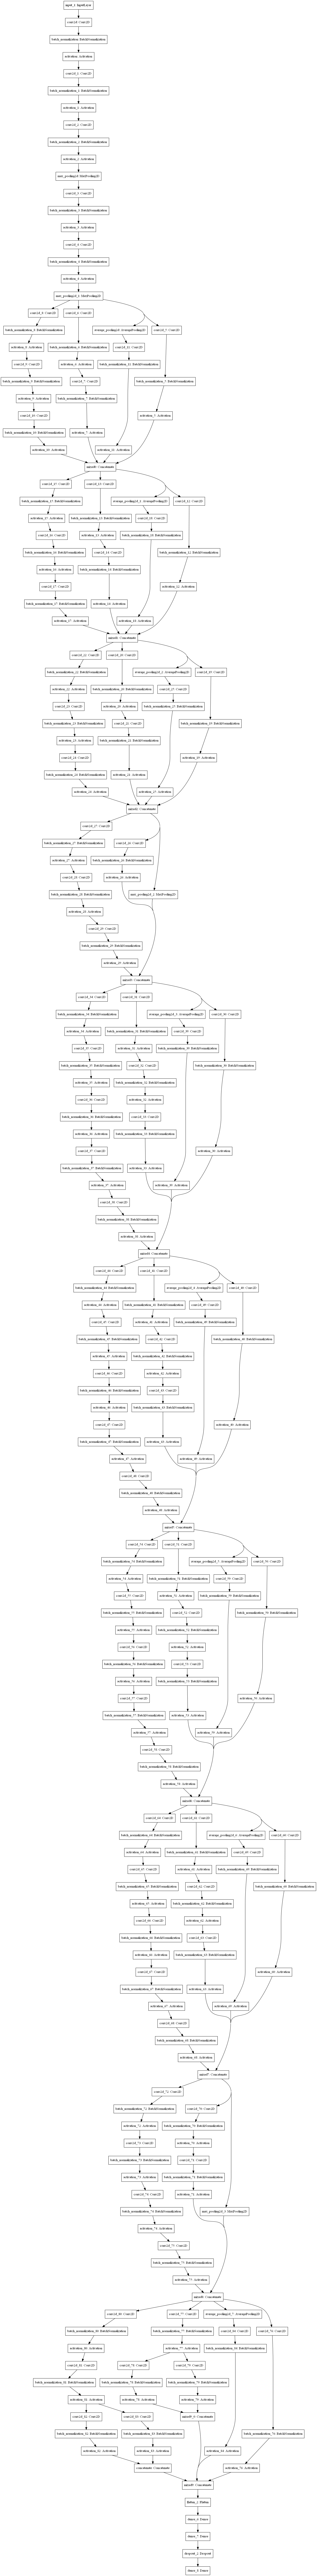

In [13]:
# ML Model

# Flatten
x = layers.Flatten()(last_output)
print(str(last_output.shape))
print(str(x.shape))

# ReLU activation
x = layers.Dense(2048, activation='relu')(x)
print(str(x.shape))
x = layers.Dense(1024, activation='relu')(x)
print(str(x.shape))

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
x = layers.Dense(len(class_dict), activation='softmax')(x)

model = Model(inception_model.input, x)
print(str(inception_model))


keras.utils.plot_model(model, to_file="Plot_the_model.png")

In [14]:
# ML Code - Adjust L_R

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [15]:
steps = 1000
ep = 3

history = model.fit(
    train_generator,
    steps_per_epoch=steps,
    validation_data = validation_generator,
    validation_steps=50,
    epochs = ep,
    verbose = 1
)

Epoch 1/3
1000/1000 [==============================] - 767s 763ms/step - loss: 0.7038 - accuracy: 0.7866 - val_loss: 0.3198 - val_accuracy: 0.8981
Epoch 2/3
1000/1000 [==============================] - 774s 774ms/step - loss: 0.3621 - accuracy: 0.8828 - val_loss: 0.2587 - val_accuracy: 0.9131
Epoch 3/3
1000/1000 [==============================] - 788s 788ms/step - loss: 0.3000 - accuracy: 0.9027 - val_loss: 0.2422 - val_accuracy: 0.9194


In [20]:
# Test the Model

test_generator.reset()
pred = model.predict_generator(
    test_generator,
    steps=test_generator.n//test_generator.batch_size,
    verbose=1
)


33/33 [==============================] - 1s 32ms/step


In [22]:
# Process Output

predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices
class_dict = {v:k for k,v in class_dict.items()}
predictions = [class_dict[k] for k in predicted_class_indices]

In [23]:
output = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})

In [24]:
# Save Output
output.to_csv('./Output/Output_' + str(steps) + '_' + str(ep) + '.csv', index=False)

In [25]:
# Compartion - Testing Image Compatison 

expected_labels = []
model_labels = []
correct = 0

with open('./Output/expected.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        expected_labels.append(row[1])

with open('./Output/Output_' + str(steps) + '_' + str(ep) + '.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        model_labels.append(row[1])

expected_labels = expected_labels[1:]
model_labels = model_labels[1:]        
        
#for i in range(len(expected_labels)):
#    print(expected_labels[i], "        ", model_labels[i])

for i in range(len(expected_labels)):
    if expected_labels[i] == model_labels[i]:
        correct += 1

        
print("Accuracy = ", (correct/33)*100, "%" )    

Accuracy =  81.81818181818183 %
